<a href="https://colab.research.google.com/github/anubhavsatpathy/EVA/blob/master/Session3/EVA_S3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and modules**

###Goal of this Assignment:

This is an assignment wherein we have been assigned a very clear objective for our model:

*Acheive at least 99.40 % validation accuracy on the MNIST dataset digit classification task*

To make our tasks resemble the real world better - we have been given two constraints to respect while going about acheiving this goal:

- *Do not use more that 20K trainable parameters*
- *Do not train the model for more than 15 epochs*
- *Do not use regularization techniques like Dropout or even LI, L2 regularization*

###Installing Keras

The cell below does the following:

- It issues a **shell command** to install the keras module into the python environment that this notebook is supposed to run in
- It imports the keras module into the program written in this notebook

For a more detailed explanation of these processes - please refer to [this notebook](https://github.com/anubhavsatpathy/EVA/blob/master/Session2/EVA_Session2.ipynb)

In [1]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


### Importing our modules

In the cell below - we import the modules, classes and methods that we will use throughout this notebook. Each of these imports have a soecific purpose that has been clearly defined [here](https://github.com/anubhavsatpathy/EVA/blob/master/Session2/EVA_Session2.ipynb)

- **ImageDataGenerator** : This is a class defined within keras that helps us transform our images so as to reduce the odds of overfitting while training - We will cover this in more detail later in this notebook ([Documentation](https://keras.io/preprocessing/image/))


In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from keras.datasets import mnist

### Load pre-shuffled MNIST data into train and test sets

The code below loads the images and labels belonging to the mnist dataset into numpy arrays. Well, it's actually not all that simple. To appreciate what the *mnist.load_data()* method has abstracted away - let's dig a little deeper:

- **Download the data** : For one, the actual files containing the images and the labels are not in the system where this program is running.  The method actually takes an argument called *PATH* that is by default an empty string. It looks up the system at <~/keras/datasets/ + PATH> for the image and label files and if not found it downloads them from the internet and stores them at that location. All non-existent directories are created on the go.

- **Convert images to arrays** : Well what gets downloaded is a *.npz* file - this is numpys way of storing arrays encountered during the runtime as tar.gz files. NumPy provides I/O utilities for these kind of files. Hence, after downloading the .npz files the method loads them into the runtime as numpy arrays

- **Returns the arrays** : The arrays thus loaded of shapes X_train(60000, 28, 28), y_train(60000), X_test(10000, 28, 28) and y_test(10000) are packed in tuples as ((X_train, y_train),(X_test,y_test)) and returned from the method 

Take note of the word **Pre Shuffled** - This reduces our headache a little bit since it means we can generate batches sequentially and pass it to our model for training. It is necessary to shuffle your dataset to avoid biases while updating the weights of your network

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


The code below does the following:

- **Printing the shape of the training images** : X_train.shape prints out the shape of the numpy ND array X_train. A shape is a property of a numpy ND array object that packs the lengths of each of it's dimentions into a tuple. In this case, the shape is *(60000, 28, 28)* standing for *(batch_size, height, width)*

- **Imports matplotlib.pyplot** : This is a plotting module used with python to plot graphs, summary plots, images and what have you.

- **Plots the first example of the training set** : Here the code uses *matplotlib.pyplot.imshow()* method to plot the 0th element of X_train which is the first training image.

*PS : %matplotlin inline is a rendering directive to matplotlib to use the console to print the plot and not a separate window*

(60000, 28, 28)


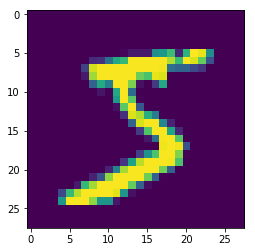

In [4]:
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[0])

The code below simply reshapes the train and test sets of images - variables named *X_train* and *X_test* respectively. Why?

Well it so happens that under the hood the *Convolution2D* layer that we imported earlier calls the tensorflow.nn.conv2D() method to create a convolution operation node in the computational graph on the network.

[This operation](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) takes an argument called data_format which defaults to *'NHCW'* - meaning that the inoput is expected in the shape *[batch_size, height, width, num_channels]*

Since mnist Images are greyscale - they contain only one color channel which we make explicit when reshaping X_train and X_test to *(train/test_set_size, 28, 28, 1)*

- X_train[0] --> train_set_size
- X-test[0] --> test_set_size 

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

The code below performs the following actions:

###Type Conversion

X_train and X_test are currently of type *numpy.uint8* which is a numpy wrapper over the unsigned 4-byte integer python datatype. We convert them to *numpy.float32*

###Input Scaling

Okay then .. why scale at all? Well think of it this way the *SGD* algorithm used to train neural networks uses the gradient of the loss w.r.t the kernels to train / update them for the next batch. Therefore, the delta in the kernel values would be proportional to the gradients which in turn would be a function of the input values

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

The code below prints the first ten labels contained in the y_train array. They represent the labels for the first 10 images of the train set

In [7]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

###One-Hot encoding of labels

The code below converts our train and test labels to their respective one-hot forms. Details about this encoding can be found [here](https://github.com/anubhavsatpathy/EVA/blob/master/Session2/EVA_Session2.ipynb)

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [9]:
Y_train[:10]


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

### Data Augmentation

Now then - this is new! MNIST is a set of 60K images for training and 10K images for validation. Neural networks in general and CNNs in particular require one of two things to learn representations of data that generalize well to the validation set:

1. More training
2. More learnable parameters
3. More and Representative Data

Since we are restricted on the first two counts by our constraints we should strive to create a richer dataset for our model to learn from. ImageDataGenerator does exactly that:

- **Creating the object** : The *ImageDataGenerator* object takes a few parameters that represent transformations that it would eventually apply to the images that are passed to it These transformations include - **Random Rotation, Random horizontal and vertical shifts, Random Zooming In and Out etc**

- **Why transform at all** : Well there is no guarantee that the images in the test set would be exactly like the images in the train set. While training our model it is very important to challenge our model using new images every epoch in order to avoid overfitting. What we acheive by transforming images is that we make our network;s prediction invariant towards these transformations that are inevitable in real life. This is a measure towards making the network more **robust**

- **flow()** : The ImageDataGenerator object has a method called flow that takes three parameters - *Training Images(Xs), Training Labels (Ys) and a batch size* - and returns a python generator that yields batch of *batch_size* elements picked from the training images and therafter transformed randomly according to the parameters passed to the ImageDataGenerator obkect

- **A python generator** : Think of this as a stateful method that allows you to return (yield) different values by maintaining a local state

Training Batch Shape : (64, 28, 28, 1)
Example of a 0


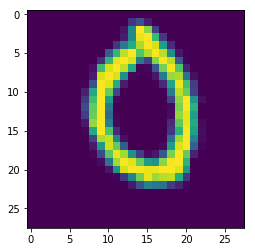

In [26]:
datagen = ImageDataGenerator(rotation_range=10,  
                             zoom_range = 0.10,  
                             width_shift_range=0.1, 
                             height_shift_range=0.1)
data_iter = datagen.flow(X_train,Y_train, batch_size = 64)
batch = data_iter.next()
print("Training Batch Shape : {}".format(batch[0].shape))
img = batch[0][3].reshape(28,28)
label = np.argmax(batch[1][3])
print("Example of a {}".format(label))
plt.imshow(img)
plt.show()

### Creating our model

Well, as discussed in class - we now try to modularize our model creation into the following steps:

- Create a block of Convolution layers of various kernel shapes and out channels
- Create a bottleneck block consisting on 2x2 max pooling and 1x1 convolution

####Why Modularize??

Well discovery of a model architecture is a fairly iterative process and we need an easier way to test our various architectures to discover the best among them - Hence modularization helps

**Disclaimer** : This is bad code - It lacks error checking etc and cannot be used by others but it does the trick for us in a short time

In [27]:
from keras.layers import Activation
from keras.layers import BatchNormalization

IP_SIZE = (28,28,1)

def add_conv_layers(layers = [(8,3,3,'relu',(28,28,1),True)], model = Sequential()):
  for layer in layers:
    if layer[4] is None:
      model.add(Convolution2D(layer[0],layer[1],layer[2], activation = layer[3]))
    else:
      model.add(Convolution2D(layer[0],layer[1],layer[2], activation = layer[3], input_shape = layer[4]))  
    
    if layer[5]:
      model.add(BatchNormalization())
      
def add_bottlenect(out_channels = 8, model = Sequential()):
  model.add(MaxPooling2D((2,2)))
  add_conv_layers(layers = [(out_channels,1,1,'relu',None,True)])
  model.add(BatchNormalization())
  
def initiate_model():
  return Sequential()
  
def build_model():
  first_conv_block = [
                      (8,3,3,'relu',IP_SIZE,True),
                      (16,3,3,'relu',None,True),
                      (30,3,3,'relu',None,True)
                      ]
  
  second_conv_block = [
                       (8,3,3,'relu',None,True),
                       (16,3,3,'relu',None,True),
                       (32,3,3,'relu',None,True),
                       (16,3,3,'relu',None,True),
                       (10,3,3,None,None,False)
                      ]
  model = initiate_model()
  add_conv_layers(layers = first_conv_block, model = model)
  add_bottlenect(out_channels = 8, model = model)
  add_conv_layers(layers = second_conv_block, model = model)
  model.add(Flatten())
  model.add(Activation('softmax'))
  return model

model = build_model()
model.summary()
  




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (3, 3), activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu")`
  if __name__ =

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization_46 (Batc (None, 26, 26, 8)         32        
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_47 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 22, 22, 30)        4350      
_________________________________________________________________
batch_normalization_48 (Batc (None, 22, 22, 30)        120       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 30)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (3, 3), activation=None)`
  if __name__ == '__main__':


### Compiling the model:

Compiling the model means that keras will actually create the computational graph using tensorflow backend. For this to happen, we need to provide a loss function and an optimizer and an accuracy metric. We define this as below:

- **Loss Function** : A loss function is a mathematical function that calculates some sort of differentiable distance measure between the network's output and the actual output for each class. During training, we average out these losses and backpropagate them through the network. In this case - we use categorical cross-entropy

- **Optimizer** : This step selects an optimizer algorithm that manipulates the learning rate per time-step so as to update the weights in a manner that does not lead to a swinging behaviour around the minimum. A few examples are *AdaGrad, Momentum etc*. but *Adam* has long been established as the king of the jungle

- **Accuracy Metric** : This is a metric that measures the performance of the network. In the case of classification this is accuracy *(i.e. number_of_correct_predictions / number_of_total_examples_in_batch)*. Well there are other measures as well like BLEU score in case of machine translation etc.

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

### Training our model:

Again - We dont **model.fit()** any more - Why not?

Well if we model.fit() we have no way to check if we reached the prescribed accuracy mark after each epoch - hence we may miss out on the best model and end up overfitting at end of the 15 permissible epochs

- **Generate the batch** : We generate the batch of images by calling next() on the generator we discussed above and we generate 6000 such batches per epoch with a batch size of 64 that results in a sample of 384000 training examples - WE JUST INFLATED OUR TRAINING SET BY OVER 6 TIMES

- **Train on the batch** : We pass the generated batch through our network - and backpropagateto update the weights

- **Break Out** : We check for validation accuracy after each epoch and stop training onve we have acheived the desired accuracy

Well - I should probably have used keras callbacks instead of this I did not want to get ahead of myself here

In [29]:
NUM_EPOCHS = 15
BATCHES_PER_EPOCH = 6000

for epoch in range(NUM_EPOCHS):
  for bat in range(BATCHES_PER_EPOCH):
    batch = data_iter.next()
    images = batch[0]
    labels = batch[1]
    model.train_on_batch(images, labels)
  score = model.evaluate(X_test, Y_test, verbose=0)[1]
  print("Validation Accuracy after epoch {} is {}".format(epoch + 1,score*100))
  if score >= 0.994:
    print("Mission Accomplished")
    break

Validation Accuracy after epoch 1 is 98.82
Validation Accuracy after epoch 2 is 98.98
Validation Accuracy after epoch 3 is 99.35000000000001
Validation Accuracy after epoch 4 is 99.33999999999999
Validation Accuracy after epoch 5 is 99.03
Validation Accuracy after epoch 6 is 99.31
Validation Accuracy after epoch 7 is 99.35000000000001
Validation Accuracy after epoch 8 is 99.46000000000001
Mission Accomplished


In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [31]:
print(score)

[0.01779608988924592, 0.9946]


In [0]:
y_pred = model.predict(X_test)

In [33]:
print(y_pred[:9])
print(y_test[:9])

[[6.46006859e-11 3.04843184e-07 2.28892459e-04 9.29456746e-06
  4.16075409e-06 1.69999161e-08 1.34760469e-07 9.99755085e-01
  5.20063793e-07 1.65892413e-06]
 [6.59233057e-10 5.16599073e-07 9.99998212e-01 2.50815968e-09
  1.05748832e-08 2.77483841e-10 2.14241496e-07 4.29423267e-07
  6.53946643e-07 1.43275614e-08]
 [1.72257572e-07 9.99975324e-01 1.42664433e-07 6.93688440e-09
  2.34889740e-07 7.08253879e-07 1.55017133e-05 6.24915356e-06
  6.86874060e-08 1.70042790e-06]
 [9.98951793e-01 1.76958252e-08 6.16295847e-06 2.40117356e-06
  4.36800207e-07 5.07844163e-07 6.75794668e-04 1.92202435e-07
  3.49677051e-04 1.30002327e-05]
 [1.46309020e-10 8.72120793e-08 5.19890186e-10 2.25797292e-09
  9.99992251e-01 1.14829541e-08 1.61534814e-07 1.20013226e-08
  3.86730790e-06 3.62222022e-06]
 [4.12398045e-08 9.99994874e-01 6.91881130e-09 1.56241642e-09
  3.14221779e-07 2.06411357e-07 1.92460675e-06 9.67379265e-07
  4.20216004e-08 1.59232627e-06]
 [5.45002724e-11 7.33009472e-07 1.76003892e-10 3.71289222e

### Seeing like the kernels

- **Serializing the layers** : model.layers() returns a flattened list of layer objects in the same sequence as they were added to the model. layer.name returns the name of that layer that we see when we print model.summary(). Think of name as a member variable of each layer object. We iterate over each of these layer objects and create a dictionary that stores the layers in the format {layer_name : layer_obj_reference}

- **layer.output** : Each layers stores its last output in a property called layer.output as a 4D tensor of shape (bat_size, k_height, k_width, num_channels)

- **Keras Backend** : These are a set of functions that provide abstractions for the mathematical operations that backends like tensorflow, theano etc. support - You can use this to create tf graphs under the hood - That is exactly what is done in the lines below that define loss and grads

- **Backend.function()** : This is equivalant of sess.run() - It takes inputs that it may pass to the tf graph using the feed_dict parameter and returns the prescribed nodes as numpy arrays

- **Update the Image** : Finally we iterate 20 times easch time updating the image so as to maximize our loss which has been set to the n-th filter's activation- Hence - the image becomes what the nth filter extracts!!

The rest of the code simply creates a matplotlib grid and prints the images to it



In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

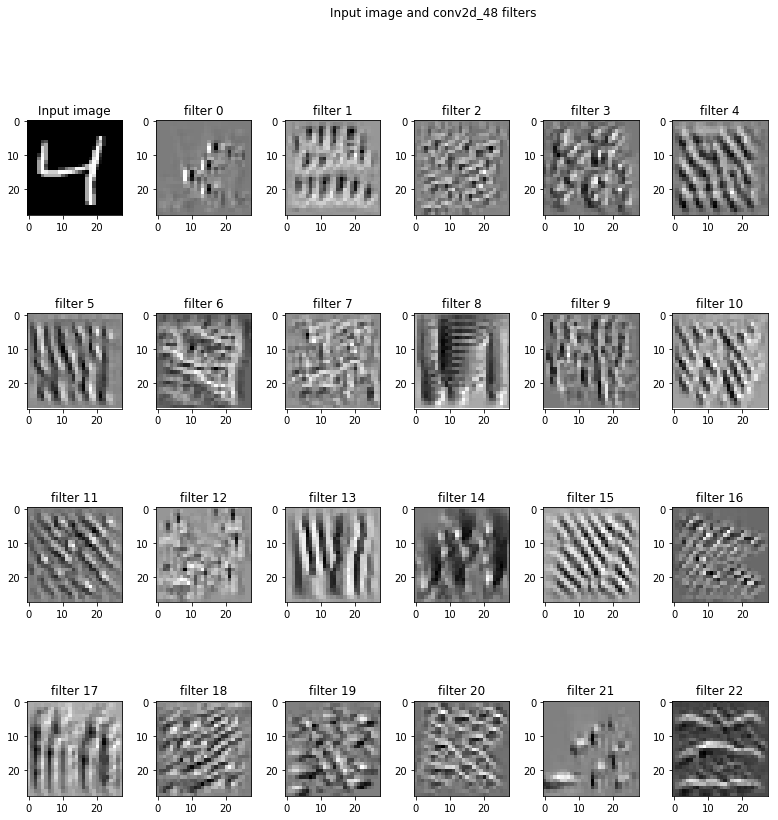

In [37]:
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
%matplotlib inline
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[2]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_48'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):   #Iterate over the channels of the output
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])   #Since the nth channel of the output is the activation of the nth filter - 

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()